In [ ]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

In [2]:
# 执行DMD
def perform_dmd(X, r):
    X1 = X[:, :-1]
    X2 = X[:, 1:]
    U, Sigma, Vt = np.linalg.svd(X1, full_matrices=False)
    U_r = U[:, :r]
    Sigma_r = np.diag(Sigma)[:r, :r]
    Vt_r = Vt[:r, :]
    A_tilde = U_r.T.conj().dot(X2).dot(Vt_r.T.conj()).dot(np.linalg.inv(Sigma_r))
    eigs, modes = np.linalg.eig(A_tilde)
    modes = X2.dot(Vt_r.T.conj()).dot(np.linalg.inv(Sigma_r)).dot(modes)
    return eigs, modes

In [3]:
# 参数与网格
alpha = 1.0  # x方向的波数
D = 0.01  # 扩散系数
N = 100  # y方向网格点的个数
y = np.linspace(-1, 1, N)
dy = y[1] - y[0]
U = 1 - y**2  # 背景流场
total_time = 2.0
dt = 0.01
time_steps = int(total_time / dt)

In [4]:
# （1）特征值问题
D2 = (sp.diags([1, -2, 1], [-1, 0, 1], shape=(N, N)) / dy**2).tolil()
D2[0, :3] = D2[-1, -3:] = [1, -2, 1] / dy**2  # Neumann边界条件
D2 = D2.tocsr()
A = sp.diags(-U * 1j * alpha, 0)
M = A + D * D2
eigenvalues, eigenvectors = spla.eigs(M, k=10, which='SM')

In [5]:
# (2): Crank-Nicolson方法
T_hat_initial = np.random.rand(N)
T_hat_initial[0] = T_hat_initial[-1] = 0
M1 = sp.eye(N) - 0.5 * dt * (D * D2 - A)
M2 = sp.eye(N) + 0.5 * dt * (D * D2 - A)
M1_csr = M1.tocsr()
M2_csr = M2.tocsr()
T_hat = T_hat_initial
T_hat_evolution = np.zeros((N, time_steps))
for t in range(time_steps):
    T_hat = spla.spsolve(M1_csr, M2_csr.dot(T_hat))
    T_hat_evolution[:, t] = np.abs(T_hat)

In [6]:
# (3): DMD
r = 10
dmd_eigenvalues, dmd_modes = perform_dmd(T_hat_evolution, r)

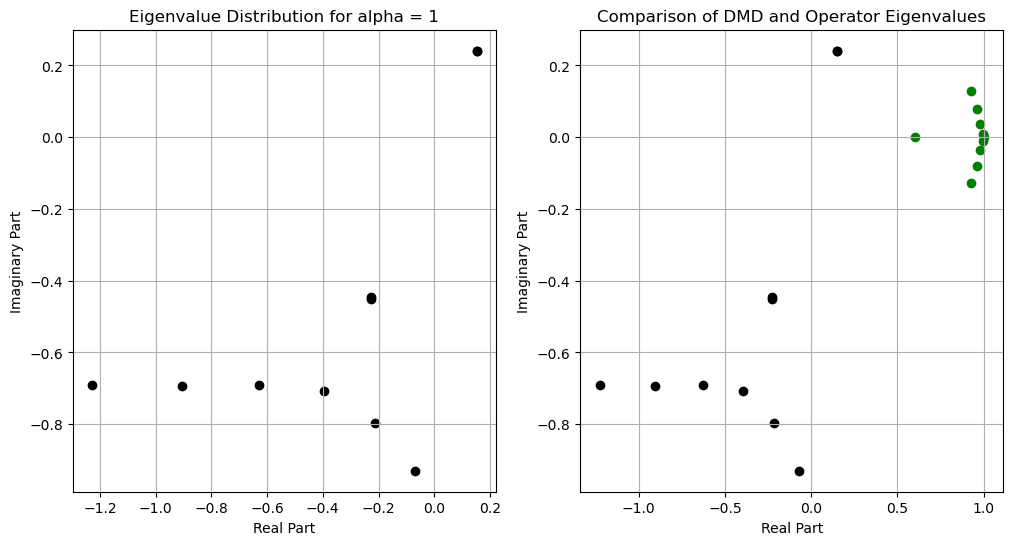

In [7]:
# （1）（3）绘图
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(eigenvalues.real, eigenvalues.imag, color='black')
plt.title('Eigenvalue Distribution for alpha = 1')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(dmd_eigenvalues.real, dmd_eigenvalues.imag, color='green')
plt.scatter(eigenvalues.real, eigenvalues.imag, color='black')
plt.title('Comparison of DMD and Operator Eigenvalues')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.grid(True)

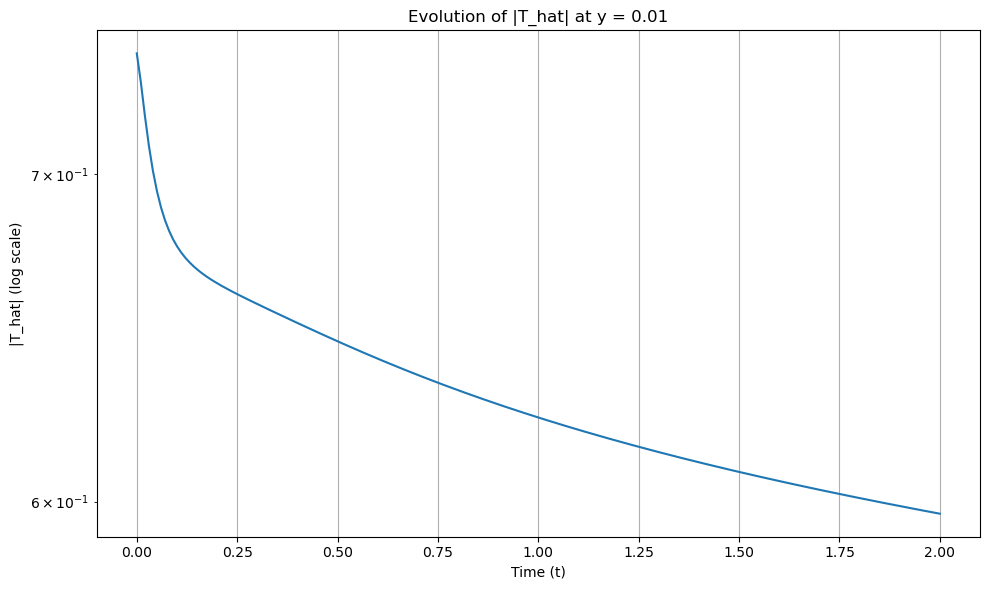

In [10]:
# （2）绘图
plt.figure(figsize=(10, 6))
y_pos = N // 2
plt.semilogy(np.linspace(0, total_time, time_steps), T_hat_evolution[y_pos, :])
plt.title(f'Evolution of |T_hat| at y = {y[y_pos]:.2f}')
plt.xlabel('Time (t)')
plt.ylabel('|T_hat| (log scale)')
plt.grid(True)

plt.tight_layout()
plt.show()